In [1]:
import xarray as xr
import xroms
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import pandas as pd

# How to interpolate to one or more points

The process shown here sets up a Delaunay triangulation to convert from longitude/latitude coordinates to grid space (xi_rho/eta_rho). Using this method, curvilinear grids from ROMS can be converted into decoupled horizontal grids. There are two interpolation schemes using this method with differences in how the vertical direction is dealt with. `xroms.interp.llzslice` uses the `xisoslice` routine is used to pull out the constant z slices for desired interpolated depth. Then, `xarray`'s own interpolation schemes can be used. Time can be subsequently interpolated. Alternatively, `xroms.interp.llzt` can be used to interpolate `z,lat,lon` triplets or `t,z,lat,lon` quadruplets by looping over each desired point individually, find the grid indices in each dimension, and then interpolate at the end. Both routines take in `zetaconstant` as a keyword for whether to let zeta and therefore the depths vary in time (`zetaconstant=False`) which is more accurate but also more time consuming, or assume that zeta doesn't vary in time so the depths can be assumed to be constant in time (`zetaconstant=True`).

The necessary routines for interpolating are in `xroms/interp.py`. They have not been generalized much at this point because it looks too complicated to do it correctly, particularly concerning the fact that xarray cannot interpolate in a dimension that is chunked over for using dask. So while the steps necessary to interpolate are clear and are shown below, they haven't been thoroughly automated for all dimensions simultaneously yet.

## Load in data

Either use the first (over the internet) or second (download) option for this work. Downloading a file preemptively might be easiest since interpolation uses a lot of points to determine the appropriate calculation.

More information at in [load_data notebook](load_data.ipynb)

In [2]:
# loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/forecast_latest/txla2_his_f_latest.nc'
# chunks = {'ocean_time':1}
# ds = xr.open_dataset(loc, chunks=chunks)

In [3]:
# # set up grid
# proj = cartopy.crs.LambertConformal(central_longitude=-98,    central_latitude=30)
# ds, grid = xroms.roms_dataset(ds, add_verts=True, proj=proj)

### Helpful to have local file for this

In [4]:
url = 'http://barataria.tamu.edu:8080/thredds/fileServer/forecast_latest/txla2_his_a_latest.nc'


In [5]:
# !wget $url

In [6]:
fname = url.split('/')[-1]
chunks = {'ocean_time': 1} #{'s_rho': 1}
ds = xr.open_dataset(fname, chunks=chunks)


In [ ]:
# set up grid
proj = cartopy.crs.LambertConformal(central_longitude=-98,    central_latitude=30)
# ds, grid = xroms.roms_dataset(ds, add_verts=True, proj=proj)
ds.xroms  # set up accessor

## Set up

Function `xroms.interp.setup` needs to be run once so that the Delaunay triangulation and functions are calculated and saved. Here, they are saved into a dictionary called `tris` and can subsequently be reused to save time.

In [7]:
# triangulation calculations
tris = xroms.interp.setup(ds)  # setup for all grids

In [ ]:
ds.xroms.interp  # have this set up?

In [ ]:
varout = ds.xroms.interp.llzslice(varin, lon0, lat0)
varout = ds.xroms.interp.llzt(varin, lon0, lat0, z0s=None, t0s=None, zetaconstant=False)


The following is to make it easier to reference the correct grid for different variables without typing it in for each.

In [8]:
# working toward streamlining connecting grids with variables
vargrid = {}
vargrid['u'] = {'s': 's_rho', 'eta': 'eta_rho', 'xi': 'xi_u', 'grid': 'u', 'z': 'z_rho_u', 'z0': 'z_rho_u0'}
vargrid['v'] = {'s': 's_rho', 'eta': 'eta_v', 'xi': 'xi_rho', 'grid': 'v', 'z': 'z_rho_v', 'z0': 'z_rho_v0'}
vargrid['w'] = {'s': 's_w', 'eta': 'eta_rho', 'xi': 'xi_rho', 'grid': 'rho', 'z': 'z_w', 'z0': 'z_w0'}
vargrid['temp'] = {'s': 's_rho', 'eta': 'eta_rho', 'xi': 'xi_rho', 'grid': 'rho', 'z': 'z_rho', 'z0': 'z_rho0'}
vargrid['salt'] = vargrid['temp']

## Interpolate to...

The following section is examples of different kinds of interpolation.

### times

Interpolating in time is straight-forward because it is 1D, uncoupled from the other dimensions, and there is no necessary mapping between the dimension and coordinate (both of which are just `ocean_time`). So, we can just use the xarray `interp` function directly with the desired times. The result is `[ocean_time x s_rho x eta x xi]`.

The potentially tricky part is that chunking cannot occur in the direction of interpolation. So, here we reset the chunking and chunk in a different dimension before interpolation, then chunk back to `ocean_time` afterward.

In [9]:
# times to interpolate to
startdate = pd.Timestamp(ds.ocean_time[0].values)
t0s = [startdate + pd.Timedelta('30 min')*i for i in range(4)]

# rechunk
ds = ds.chunk(-1).chunk({'s_rho': 1})

# interpolation
ds.interp(ocean_time=t0s).chunk({'ocean_time':1})

<xarray.Dataset>
Dimensions:         (eta_rho: 191, eta_v: 190, eta_vert: 192, ocean_time: 4, s_rho: 30, s_w: 31, tracer: 6, xi_rho: 671, xi_u: 670, xi_vert: 672)
Coordinates:
  * s_rho           (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w             (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lon_u           (eta_rho, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
    lat_u           (eta_rho, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
    lon_v           (eta_v, xi_rho) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
    lat_v           (eta_v, xi_rho) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
    lon_psi         (eta_v, xi_u) float64 dask.array<chunksize=(190, 670), meta=np.ndarray>
    lat_psi         (eta_v, xi_u) float64 dask.array<chunksize=(190, 670), meta=np.ndarray>
    z_w             (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 191, 671), meta=np.ndarray>
    z_w_u           (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 31, 191, 670), meta=np.ndarray>
    z_w_v           (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 31, 190, 671), meta=np.ndarray>
    z_w_psi         (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 31, 190, 670), meta=np.ndarray>
    z_rho           (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 1, 191, 671), meta=np.ndarray>
    z_rho_u         (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 1, 191, 670), meta=np.ndarray>
    z_rho_v         (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 1, 190, 671), meta=np.ndarray>
    z_rho_psi       (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 1, 190, 670), meta=np.ndarray>
    z_rho0          (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 191, 671), meta=np.ndarray>
    z_rho_u0        (s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 191, 670), meta=np.ndarray>
    z_rho_v0        (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 190, 671), meta=np.ndarray>
    z_rho_psi0      (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 190, 670), meta=np.ndarray>
    z_w0            (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 191, 671), meta=np.ndarray>
    z_w_u0          (s_w, eta_rho, xi_u) float64 dask.array<chunksize=(31, 191, 670), meta=np.ndarray>
    z_w_v0          (s_w, eta_v, xi_rho) float64 dask.array<chunksize=(31, 190, 671), meta=np.ndarray>
    z_w_psi0        (s_w, eta_v, xi_u) float64 dask.array<chunksize=(31, 190, 670), meta=np.ndarray>
    lon_vert        (eta_vert, xi_vert) float64 dask.array<chunksize=(192, 672), meta=np.ndarray>
    lat_vert        (eta_vert, xi_vert) float64 dask.array<chunksize=(192, 672), meta=np.ndarray>
  * ocean_time      (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-...
Dimensions without coordinates: eta_rho, eta_v, eta_vert, tracer, xi_rho, xi_u, xi_vert
Data variables:
    ntimes          int32 4320
    ndtfast         int32 40
    dt              float64 20.0
    dtfast          float64 0.5
    dstart          datetime64[ns] 2018-10-30
    shuffle         int32 1
    deflate         int32 1
    deflate_level   int32 1
    nHIS            int32 180
    ndefHIS         int32 0
    nRST            int32 4320
    nSTA            int32 180
    Falpha          float64 2.0
    Fbeta           float64 4.0
    Fgamma          float64 0.284
    nl_tnu2         (tracer) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    nl_visc2        float64 5.0
    LuvSponge       int32 1
    LtracerSponge   (tracer) int32 dask.array<chunksize=(6,), meta=np.ndarray>
    Akt_bak         (tracer) float64 dask.array<chunksize=(6,), m

### multiple lon, lat locations (1D)

The thing that is tricky about interpolation with a ROMS grid in the xarray environment is that dimensions of xarray DataArrays are indices in grid space, but the grid itself may be curvilinear and is defined in either projected or geographic space. If the grid is curvilinear, it is not directly separable into the grid dimensions `eta` and `xi`. Instead, we have to first interpolate onto grid space to calculate the `eta` and `xi` coordinates that match desired longitude/latitude coordinate pairs. Once we know the desired grid space coordinates, it is easy to [interpolate in xarray](http://xarray.pydata.org/en/stable/interpolation.html) using the familiar `isel`- and `sel`-style syntax but with `interp` instead.

In the following example, we interpolate salinity to points defined in lon/lat; preserving input times and water columns. The result is dimensions `[ocean_time x s_rho x pts]`. Reduce the number of sigma levels or times included in the result by selecting with `sel` or `isel` before or after the interpolation call.

If the surface sigma level and all times are selected, this could be useful for interpolation to buoy locations.

In [10]:
# want salt at the following coords
ie, ix = [24, 116, 121, 30], [31, 198, 439, 342]
lon0, lat0 = np.diag(ds.lon_rho[ie,ix]), np.diag(ds.lat_rho[ie,ix])
varin = ds.salt
trisgrid = tris[vargrid[varin.name]['grid']]
varcomp = np.diag(varin.isel(eta_rho=ie, xi_rho=ix, ocean_time=0, s_rho=-1))  # compare 1 time and 1 sigma level

Interp method 1, with `xroms.interp.llzslice`:

In [11]:
%%timeit
varout = xroms.interp.llzslice(varin, trisgrid, lon0, lat0)
assert np.allclose(varout.isel(ocean_time=0, s_rho=-1), varcomp)

1.58 s ± 33.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Interp method 2, with `xroms.interp.llzt`:

In [12]:
%%timeit
varout = xroms.interp.llzt(varin, trisgrid, lon0, lat0, z0s=None, t0s=None, zetaconstant=False)
assert np.allclose(varout.isel(ocean_time=0, s_rho=-1), varcomp)

1.62 s ± 95.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The times are about the same regardless of which interpolation function is used, and we get the same results.

Below we calculate `varout` again since `timeit` doesn't save the results into the variables.

In [13]:
# run again to use values in next plot
varout = xroms.interp.llzt(varin, trisgrid, lon0, lat0, z0s=None, t0s=None, zetaconstant=False)

Note that you can retrieve grid information about the interpolation points from the object DataArray:

    var.ocean_time, var.eta_rho, var.xi_rho

Plot the interpolated salinity overlaid on the full field to visually check.

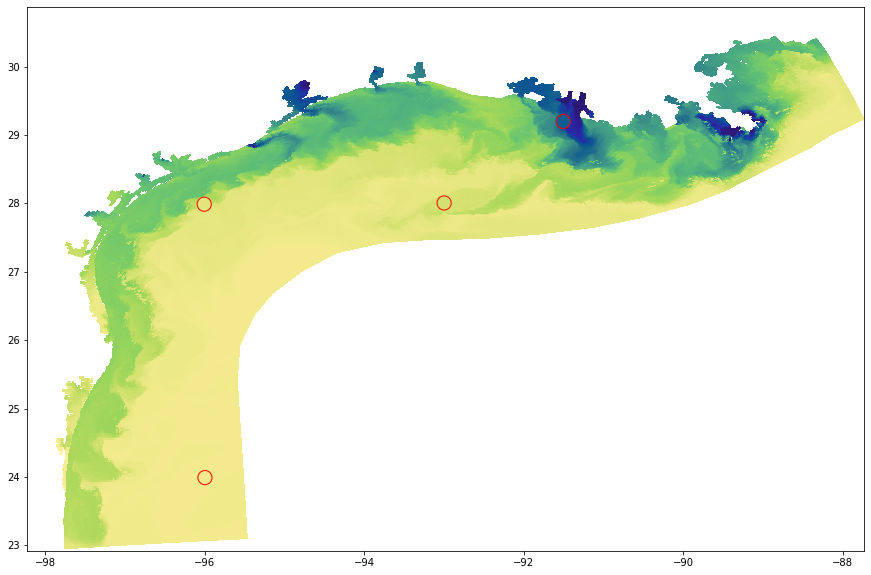

In [14]:
indexer = {'ocean_time': 0, 's_rho': -1}
salt = ds.salt.isel(indexer)
vmin = salt.min().values; vmax = salt.max().values

fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.pcolormesh(ds.lon_vert, ds.lat_vert, salt, cmap=cmo.haline)  # full field
ax.scatter(lon0, lat0, c=varout.isel(indexer), s=200, edgecolor='r', vmin=vmin, vmax=vmax, cmap=cmo.haline)

### single lon, lat location at interpolated depths and times

Interpolate salinity at one lon/lat location to a range of depths and times. The result is `[ocean_time x z]`.

A shipboard CTD cast could be compared to model output with this approach.

In [20]:
# want salt at the following coords
ie, ix = 121, 439
lon0, lat0 = ds.lon_rho[ie,ix], ds.lat_rho[ie,ix]
iz0s = [4,14]
startdate = pd.Timestamp(ds.ocean_time[0].values)
t0s = [startdate + pd.Timedelta('30 min')*i for i in range(6)]
varin = ds.temp
z0s = varin.z_rho.isel(eta_rho=ie, xi_rho=ix, s_rho=iz0s, ocean_time=0)
z0s2 = varin.z_rho0.isel(eta_rho=ie, xi_rho=ix, s_rho=iz0s)
varcomp = varin.isel(eta_rho=ie, xi_rho=ix, s_rho=iz0s)
trisgrid = tris[vargrid[varin.name]['grid']]

# lazily do the interpolation
var = xroms.interp.llzslice(varin, tris[vargrid[varin.name]['grid']], lon0, lat0, z0s)
var2 = xroms.interp.llzslice(varin, tris[vargrid[varin.name]['grid']], lon0, lat0, z0s2, zetaconstant=True)

# rechunk
var = var.chunk(-1).chunk({'z': 1})
var2 = var2.chunk(-1).chunk({'z': 1})

# interpolation
var = var.interp(ocean_time=t0s).chunk({'ocean_time':1})
var2 = var2.interp(ocean_time=t0s).chunk({'ocean_time':1})

assert np.allclose(var.isel(ocean_time=0), varcomp.isel(ocean_time=0), rtol=1e-3)

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Also check timing. To compare performance for this sort of scenario that is not specifically triplets (having x,y,z choices for more times is not possible with triplet with `zetaconstant` is False), turn `zetaconstant` to True so time is considered separately.
Also whereas `llzslice` can take in 1 lon/lat coordinate and 2 depths and return 2 points, `llzt` expects exactly the same size for these inputs too, so lon0 and lat0 are repeated to make a comparison.

In [21]:
%%timeit
var = xroms.interp.llzslice(varin, trisgrid, lon0, lat0, z0s, zetaconstant=True)
var = var.chunk(-1).chunk({'z': 1})
var = var.interp(ocean_time=t0s).chunk({'ocean_time':1})
assert np.allclose(var.isel(ocean_time=0), varcomp.isel(ocean_time=0), rtol=1e-2)

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/o

28.6 s ± 843 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
lon0 = float(lon0); lat0 = float(lat0)

In [23]:
%%timeit
varout = xroms.interp.llzt(varin.chunk(-1), trisgrid, [lon0,lon0], [lat0,lat0], z0s=z0s2, t0s=None, zetaconstant=True)
varout = varout.chunk(-1).interp(ocean_time=t0s)  # reset time chunks
# assert np.allclose(varout, varcomp.isel(ocean_time=np.arange(len(t0s))), rtol=1e-2)
assert np.allclose(varout.isel(ocean_time=0), varcomp.isel(ocean_time=0), rtol=1e-2)

3.95 s ± 75.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


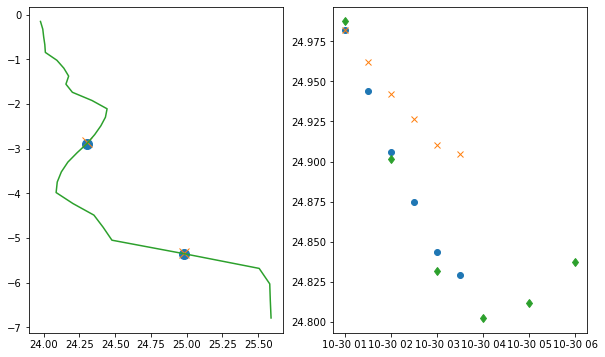

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

# demonstrate result for 1 water column calculation
varp = var.isel(ocean_time=0)
varp2 = var2.isel(ocean_time=0)
# compare with neighboring point
dss = varin.isel(xi_rho=ix, eta_rho=ie)
dssz = dss.isel(ocean_time=0)

axes[0].plot(varp, varp.z, marker='o', linestyle='', markersize=10)
axes[0].plot(varp2, varp2.z, marker='x', linestyle='', markersize=10)
axes[0].plot(dssz, dssz.z_rho)


# demonstrate 1 time series
vart = var.isel(z=0)
vart2 = var2.isel(z=0)
# compare with un-interpolated output
dsst = dss.isel(s_rho=iz0s[0], ocean_time=slice(0,6))

axes[1].plot(vart.ocean_time, vart, marker='o', linestyle='')
axes[1].plot(vart2.ocean_time, vart2, marker='x', linestyle='')
axes[1].plot(dsst.ocean_time, dsst, marker='d', linestyle='')


The interpolated model output is plotted with model output with depth (left) and in time (right). Note that on the left, the blue markers show the interpolation results when allowing zeta to vary with time whereas the orange markers show them with zeta constant. They are almost the same but taking zeta as constant saves time! On the right side, the blue markers deviate in time because they are set to the 0 time depth. Using `zetaconstant=True` stays closer to the true depth in time.

### single lon,lat location with several depths for s_w grid

The $w$ velocity is calculated at `s_w` vertical grid nodes.

In [25]:
zetaconstant = True

# want salt at the following coords
ie, ix = 121, 439
lon0, lat0 = ds.lon_rho[ie,ix], ds.lat_rho[ie,ix]
iz0s = [4,14]
t0s = ds.isel(ocean_time=slice(0,3)).ocean_time
varin = ds.w
trisgrid = tris[vargrid[varin.name]['grid']]

if zetaconstant:
    z0s = ds.z_w0[iz0s,ie,ix]
else:
    z0s = ds.z_w[0,iz0s,ie,ix]

varcomp = varin.sel(ocean_time=t0s).isel(s_w=iz0s, eta_rho=ie, xi_rho=ix)


In [33]:
%%timeit
var = xroms.interp.llzslice(varin, trisgrid, lon0, lat0, z0s, zetaconstant=zetaconstant)

# rechunk
var = var.chunk(-1).chunk({'z': 1})

# interpolation
var = var.interp(ocean_time=t0s).chunk({'ocean_time':1})
var = var.transpose('ocean_time','z')

assert np.allclose(var, varcomp, rtol=1e-1)

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/o

9.58 s ± 1.83 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
lon0 = float(lon0); lat0 = float(lat0)

In [35]:
%%timeit
varout = xroms.interp.llzt(varin.chunk(-1), trisgrid, [lon0,lon0], [lat0,lat0], z0s=z0s, t0s=None, zetaconstant=True)
varout2 = varout.chunk(-1).interp(ocean_time=t0s)  # reset time chunks
varout = varout2.isel(ocean_time=np.arange(len(t0s)))  # pull triplets out
assert np.allclose(varout, varcomp)

4.52 s ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### array of grid nodes (2D) regridded to several water depths

Select v velocity for the full horizontal grid, then interpolate to z and preserve time.

This is a way to convert model output from sigma to fixed z depths. For this, we can directly used the function `calc_zslices` that is used in `llzslice`. This should clearly be done with this approach and not with function `xroms.interp.llzt`.

In [36]:
z0s = [-20,-10]
varin = ds.v

sl = xroms.interp.calc_zslices(varin, z0s, zetaconstant=True)
print(sl)

<xarray.DataArray (z: 2, ocean_time: 24, eta_v: 190, xi_rho: 671)>
dask.array<concatenate, shape=(2, 24, 190, 671), dtype=float64, chunksize=(1, 24, 190, 671), chunktype=numpy.ndarray>
Coordinates:
    lon_v       (eta_v, xi_rho) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31
  * z           (z) int64 -20 -10
Dimensions without coordinates: eta_v, xi_rho


### array of lon, lat locations (2D)

Interpolate u velocity to an array of lon/lat points; preserve input times and water columns. Result is `[ocean_time x s_rho x eta_pts x xi_pts]`.

This could be useful for interpolating to an HF Radar field if just the surface is selected.

In [47]:
npts = 5
lon0, lat0 = np.linspace(-96, -95,npts), np.linspace(27,28,npts+1)
LON0, LAT0 = np.meshgrid(lon0, lat0)
varin = ds.u
trisgrid = tris[vargrid[varin.name]['grid']]

xi0, eta0 = xroms.interp.ll2xe(trisgrid, LON0, LAT0)
var0 = varin.interp(eta_rho=eta0, xi_u=xi0)
var1 = xroms.interp.llzslice(varin, trisgrid, LON0, LAT0)
var2 = xroms.interp.llzt(varin, trisgrid, LON0, LAT0)

assert np.allclose(var0, var1)
assert np.allclose(var1, var2)

### multiple z, y, x locations

Interpolate temperature to several specific (z,y,x) locations and include all available times. The result is `[ocean_time x pts]`. Note that inputting the flag `zetaconstant=True` will speed up the calculation by calculating the depth only once and with respect to mean sea level instead of allowing zeta to vary with time in the calculation.

This could be useful for interpolating to match several data stations that are not at the surface.

In [38]:
zetaconstant = True

# want salt at the following coords
ie, ix = [24, 116, 121, 29], [31, 198, 439, 341]
lon0, lat0 = np.diag(ds.lon_rho[ie,ix]), np.diag(ds.lat_rho[ie,ix])
iz0s = [10, 3, 15, 8]
varin = ds.temp
trisgrid = tris[vargrid[varin.name]['grid']]

z0s = varin.z_rho0.isel(s_rho=xr.DataArray(iz0s, dims="pts"), 
                eta_rho=xr.DataArray(ie,dims="pts"), 
                xi_rho=xr.DataArray(ix,dims="pts"))

varcomp = varin.isel(s_rho=xr.DataArray(iz0s, dims="pts"), 
                    eta_rho=xr.DataArray(ie,dims="pts"), 
                    xi_rho=xr.DataArray(ix,dims="pts"))


In [44]:
%%timeit
var = xroms.interp.llzslice(varin, trisgrid, lon0, lat0, z0s, zetaconstant=zetaconstant, triplets=True)
var = var.transpose('ocean_time',...)
assert np.allclose(var, varcomp, rtol=1e-2)

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/o

10.6 s ± 419 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit
varout = xroms.interp.llzt(varin.chunk(-1), trisgrid, lon0, lat0, z0s=z0s, t0s=None, zetaconstant=True)
assert np.allclose(varout, varcomp)

4.59 s ± 202 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### multiple t, z, y, x locations

To interpolate in time in addition to z,y,x (previous example), we can simply interpolate in time after interpolating in the other dimensions first. Additional complexity can come if chunking is in the `ocean_time` dimension, in which case the chunking first has to change before interpolation. (The same is true before interpolation in any dimension, but the example on this page is read in with chunking only in `ocean_time`.)

This approach could be used for interpolating model output to compare directly with glider or ship tracks.

In [48]:
zetaconstant = False

# want salt at the following coords
ie, ix = [24, 116, 121, 29], [31, 198, 439, 341]
lon0, lat0 = np.diag(ds.lon_rho[ie,ix]), np.diag(ds.lat_rho[ie,ix])
iz0s = [10, 3, 15, 8]
it0s = np.arange(0,len(iz0s))
t0s = ds.isel(ocean_time=it0s).ocean_time
varin = ds.salt
trisgrid = tris[vargrid[varin.name]['grid']]

z0s = ds.z_rho.isel(s_rho=xr.DataArray(iz0s, dims="pts"), 
                  eta_rho=xr.DataArray(ie,dims="pts"), 
                  xi_rho=xr.DataArray(ix,dims="pts"),
                  ocean_time=xr.DataArray(it0s,dims="pts"))

varcomp = varin.isel(s_rho=xr.DataArray(iz0s, dims="pts"), 
                    eta_rho=xr.DataArray(ie,dims="pts"), 
                    xi_rho=xr.DataArray(ix,dims="pts"),
                    ocean_time=xr.DataArray(it0s,dims="pts"))


In [55]:
%%timeit
varout = xroms.interp.llzslice(varin, trisgrid, lon0, lat0, z0s, zetaconstant=zetaconstant, triplets=True)
varout = varout.chunk(-1).interp(ocean_time=t0s)  # reset time chunks
varout = varout.isel(ocean_time=xr.DataArray(it0s,dims="pts"))  # pull triplets out
assert np.allclose(varout, varcomp, rtol=1e-3)

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/o

53.3 s ± 372 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%%timeit
varout = xroms.interp.llzt(varin.chunk(-1), trisgrid, lon0, lat0, z0s=z0s, t0s=t0s, zetaconstant=zetaconstant)
assert np.allclose(varout, varcomp)

35.3 s ± 736 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Cross-section

A cross-section can be calculated using `xisoslice` from `xroms`. A short example will be given here, but more details are available in the [select_data notebook](select_data.ipynb). 3D interpolation in this notebook uses `xisoslice` to calculate `s_rho` indices.

Calculate cross-section of u-velocity along latitude of 27 degrees.

In [57]:
lat0 = 27
varin = ds.u

sl = xroms.xisoslice(varin['lat_u'], lat0, varin, vargrid[varin.name]['eta'])

print(sl)

<xarray.DataArray (ocean_time: 24, s_rho: 30, xi_u: 670)>
dask.array<sub, shape=(24, 30, 670), dtype=float64, chunksize=(24, 1, 670), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31
Dimensions without coordinates: xi_u


## Get grid indices out

They are stored in an interpolated DataArray.

Note that:
* `eta` and `xi` grid indices do not change in time and thus can be reused, but are different for different grids.
* if flag `zetaconstant=True` is used, then changes in zeta in time are not considered when calculating sigma grid indices and therefore are not dependent on time, in which case they also can be reused for a given (z,y,x) triplet. However, if time is being considered such that z is time-varying, then a given sigma grid index is specific to the t,z,y,x 4D time/location.